18
 0 : 128 dots
 1 : 50 dots
 2 : 20 dots
 3 : 24 dots
 4 : 11 dots
 5 : 11 dots
 6 : 11 dots
 7 : 11 dots
 8 : 3 dots
 9 : 3 dots
 10 : 3 dots
 11 : 3 dots
 12 : 2 dots
 13 : 2 dots
 14 : 2 dots
 15 : 2 dots
 16 : 2 dots
 17 : 2 dots


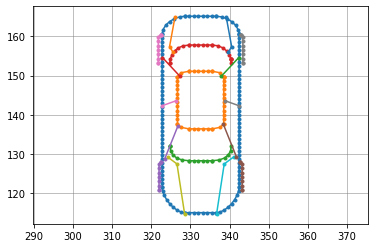

label size = 1
(128, 36)


In [1]:
## Python basics for novice data scientists, supported by Wagatsuma Lab@Kyutech 
#
# The MIT License (MIT): Copyright (c) 2021 Hiroaki Wagatsuma and Wagatsuma Lab@Kyutech
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. */
#
# # @Time    : 2022-10-16 
# # @Author  : Hiroaki Wagatsuma
# # @Site    : https://github.com/hirowgit/2B0_python_optmization_course
# # @IDE     : Python 3.9.14 (main, Sep  6 2022, 23:29:09) [Clang 13.1.6 (clang-1316.0.21.2.5)] on darwin
# # @File    : SVG_converter_Platinum.py


import numpy as np
import matplotlib.pyplot as plt
import os

from svg.path import parse_path
from svg.path.path import Line
from xml.dom import minidom

from time import time
import pandas as pd

def line_splitter(start, end):
    return (lambda t: (1-t)*start+t*end)

def cubic_bezier_converter(start, control1, control2, end):
    original_data = np.array([start, control1, control2, end])
    cubic_bezier_matrix = np.array([
        [-1,  3, -3,  1],
        [ 3, -6,  3,  0],
        [-3,  3,  0,  0],
        [ 1,  0,  0,  0]
    ])
    return_data = cubic_bezier_matrix.dot(original_data)

    return (lambda t: np.array([t**3, t**2, t, 1]).dot(return_data))

# On the design of "cubic_bezier_converter" was learned from
# https://stackoverflow.com/questions/36971363/how-to-interpolate-svg-path-into-a-pixel-coordinates-not-simply-raster-in-pyth
datafol_in='data'
datafol_out='output'

inputF='B_sample.svg'
inputF='LaneMap2.svg'
inputF='CarShapeF.svg'

#  --- path (including CubicBezier) ---
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
# path_strings = [path.getAttribute('d') for path
#                 in doc.getElementsByTagName('polyline')]
doc.unlink()

# KL=3
points_np_all2=[]
points_np_all=np.empty((len(path_strings)),dtype=object)
# points_np_all=np.empty((KL),dtype=object)
# print(len(points_np_all))

for k in range(len(path_strings)):
# for k in range(KL):
#for path_string in path_strings:
    path = parse_path(path_strings[k])
    points_np_merge=np.empty((0,2), float)
#     k2=1
    for dat in path:
#         print([str(k2),type(dat).__name__])
        if type(dat).__name__=='CubicBezier':
#             print('CubicBezier')
            start_np = np.array([dat.start.real, dat.start.imag])
            control1_np = np.array([dat.control1.real, dat.control1.imag])
            control2_np = np.array([dat.control2.real, dat.control2.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            converted_curve = cubic_bezier_converter(start_np, control1_np, control2_np, end_np)
            # 
            diff_np=start_np-end_np
            n_dots=np.round(np.linalg.norm(diff_np)).astype(int)
            # 
            points_np = np.array([converted_curve(t) for t in np.linspace(0, 1, n_dots)])
        elif type(dat).__name__=='Line':
#             print('Line')
            start_np = np.array([dat.start.real, dat.start.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            converted_line = line_splitter(start_np,end_np)
            # 
            diff_np=start_np-end_np
            n_dots=np.round(np.linalg.norm(diff_np)).astype(int)
            #     
            points_np=np.array([converted_line(t) for t in np.linspace(0, 1, n_dots)])
        elif type(dat).__name__=='Move':
#             print('Move')
            # 
            n_dots=1
            # 
            start_np = np.array([dat.start.real, dat.start.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            points_np = np.array([start_np,end_np])
        else:
            points_np=np.array([])
        #points_np_merge=np.concatenate(points_np_merge,points_np)
        if np.shape(points_np)[0]>0:
                points_np_merge=np.append(points_np_merge, points_np, axis=0)
#         k2=k2+1
    points_np_all[k]= points_np_merge
#     print(' %d : %d dots' % (k,len(points_np_merge)))

points_np_all2=points_np_all

#  --- polylines ---
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('points') for path
                in doc.getElementsByTagName('polyline')]
# path_strings = [path.getAttribute('d') for path
#                 in doc.getElementsByTagName('polyline')]
doc.unlink()

points_np_merge=[]
points_np_all=np.empty((len(path_strings)),dtype=object)

for k in range(len(path_strings)):
    kd=path_strings[k]
    pointD=[d.split(',') for d in kd.split(' ') if len(d)>0]
#     points_np=np.array([[float(d[0]),float(d[1])] for d in pointD])
    points_np=np.array([[float(d[0]),float(d[1])] for d in pointD])
    points_np_all[k]=points_np
#     points_np_all[k]= np.append(points_np_merge, points_np, axis=0)
#     points_np_all[k]= points_np_merge

# print(points_np_all)
    
points_np_all2=np.append(points_np_all2,points_np_all)
# points_np_all2

#  --- lines ---
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [[path.getAttribute('x1'),path.getAttribute('y1'),path.getAttribute('x2'),path.getAttribute('y2')]  for path
                in doc.getElementsByTagName('line')]
doc.unlink()
path_strings


points_np_merge=[]
points_np_all=np.empty((len(path_strings)),dtype=object)

for k in range(len(path_strings)):
    kd=path_strings[k]
    points_np=np.array([[float(kd[0]),float(kd[1])],[float(kd[2]),float(kd[3])]])
    points_np_all[k]=points_np
    
# print(points_np_all)    
points_np_all2=np.append(points_np_all2,points_np_all)
# points_np_all2

points_np_all=points_np_all2
print(len(points_np_all2))

for k in range(len(points_np_all2)):
    print(' %d : %d dots' % (k,len(points_np_all2[k])))

fig1, ax = plt.subplots()
# plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.grid(color=[0.5,0.5,0.5], linestyle='-', linewidth=0.5)

for k in range(len(points_np_all)):
    points_np=points_np_all[k]
    plt.plot(points_np[:, 0], points_np[:, 1], '.-')
ax.axis('equal')
plt.show()

maxL=max(len(points_np_all[k]) for k in range(len(points_np_all)))

label=np.empty([],dtype='unicode')
print("label size = %d" % (label.size))
label=[]
for k in range(len(points_np_all)): 
    label=np.append(label,["x%d"%(k+1),"y%d"%(k+1)])
dat_df = pd.DataFrame([],columns=label)
for k in range(len(points_np_all)):
    points_np=points_np_all[k]
    tmp0=np.zeros([maxL,2])
    tmp0[0:points_np.shape[0],:]=points_np
    dat_df["x%d"%(k+1)] = tmp0[:,0]
    dat_df["y%d"%(k+1)] = tmp0[:,1]
    
print(dat_df.shape)
dat_df

outF=inputF.split('.')[0]+'_full.csv'
dat_df.to_csv(os.path.join(datafol_out,outF))